In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import csv

Using TensorFlow backend.


In [2]:
no_MFCC=13
no_MFCC_sample=20


In [115]:
def get_labels(path):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

def speech2mfcc(file_path,max_len=11):
    wave, SR= librosa.load(file_path, mono=True, sr=None)
    #wave=wave[::5]
    mfcc=librosa.feature.mfcc(wave,sr=SR, n_mfcc=no_MFCC)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

def save_data_to_array(path, data_path, max_len=11):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path +"/"+ label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            wave, sr= librosa.load(speech, mono=True, sr=None)
            mfcc=speech2mfcc(speech,max_len=max_len )
            mfcc_vectors.append(mfcc)
            
        print(np.shape(mfcc_vectors))
        np.save(data_path+"/"+label+'.npy',mfcc_vectors)


In [114]:

#SOUND_PATH="./Vowel_Data/Vowel"
#DATA_PATH="./Vowel_Data/MFCC"

SOUND_PATH="./Word_Data/Word"
DATA_PATH="./Word_Data/MFCC"

#save_data_to_array(SOUND_PATH, DATA_PATH,no_MFCC_sample )
#F:\MAHBUB\STUDY\Student_researches\Rakib\Vowel_Data\Vowel_sound 

In [116]:
def get_train_test(split_ratio=1,random_state=42):
    labels,indices,_=get_labels(SOUND_PATH) # For label reading its need sound file locations

    X=np.load(DATA_PATH+'/'+labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(DATA_PATH+'/'+label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    time_var=np.var(X, axis=2)
    avg_var=np.mean(time_var, axis=0)
    plt.plot(avg_var)
    plt.show()
    #np.save(DATA_PATH+'vowel_MFCC_var'+'.csv',time_var)
    assert X.shape[0] == len(y)
    #print(time_var.shape)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True)

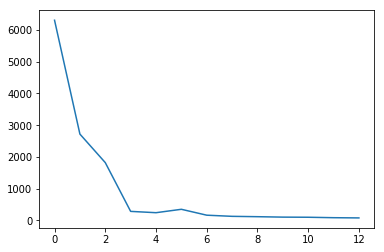

(280, 13, 20)
260
(280, 260)


In [117]:
X_train, X_test, y_train, y_test=get_train_test()
print(X_train.shape)
tot_no_MFCC=X_train.shape[1]*X_train.shape[2]
print(tot_no_MFCC)
X_train=X_train.reshape((X_train.shape[0],tot_no_MFCC))
print(X_train.shape)
y_train_hot=to_categorical(y_train)
#y_test_hot=to_categorical(y_test)

In [118]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Epoch 1/40
280/280 [==============================] - 0s 2ms/step - loss: 2.1558 - acc: 0.1429
Epoch 2/40
280/280 [==============================] - 0s 325us/step - loss: 2.1005 - acc: 0.1429
Epoch 3/40
280/280 [==============================] - 0s 297us/step - loss: 2.0819 - acc: 0.1429
Epoch 4/40
280/280 [==============================] - 0s 349us/step - loss: 2.0692 - acc: 0.1429
Epoch 5/40
280/280 [==============================] - 0s 328us/step - loss: 2.0595 - acc: 0.1429
Epoch 6/40
280/280 [==============================] - 0s 334us/step - loss: 2.0518 - acc: 0.1429
Epoch 7/40
280/280 [==============================] - 0s 561us/step - loss: 2.0456 - acc: 0.1429
Epoch 8/40
280/280 [==============================] - 0s 615us/step - loss: 2.0404 - acc: 0.1429
Epoch 9/40
280/280 [==============================] - 0s 499us/step - loss: 2.0361 - acc: 0.1429
Epoch 10/40
280/280 [==============================] - 0s 325us/step - loss: 2.0322 - acc: 0.1429
Epoch 11/40
280/280 [==========

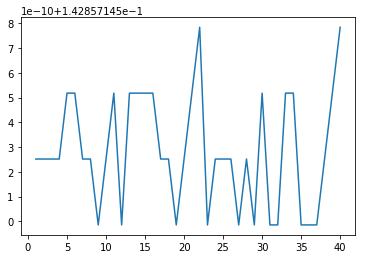

In [119]:
network=Sequential()
network.add(Dense(16, activation='tanh', input_shape=(tot_no_MFCC,)))
#network.add(Dense(32, activation='tanh'))
#network.add(Dense(16, activation='tanh'))
#network.add(Dense(16, activation='tanh'))
network.add(Dense(7, activation='softmax'))
opt = SGD(lr=0.001, momentum=0.1, decay=0.01)
network.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
#network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history=network.fit(X_train, y_train_hot, epochs=40, batch_size=5)

accuracy=history.history['acc']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy)
plt.show()

In [120]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 16)                4176      
_________________________________________________________________
dense_36 (Dense)             (None, 7)                 119       
Total params: 4,295
Trainable params: 4,295
Non-trainable params: 0
_________________________________________________________________


In [121]:
n_classes=7
from sklearn.metrics import roc_curve, auc
y_pred = network.predict(X_train)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_hot[:, i],y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
myFile=open('./Result/AUC_ROC/AUC_ROC_compare','a')

myFile.write("\nWord_Layer size 16_7:\n")

with myFile:
    writer=csv.writer(myFile)
    writer.writerow(roc_auc.values())

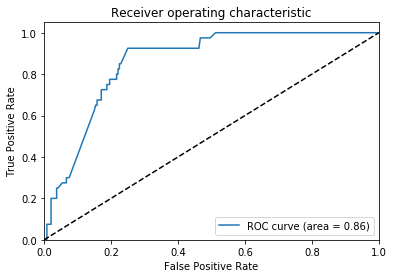

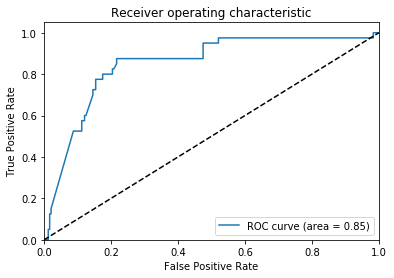

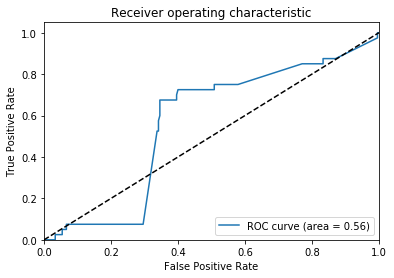

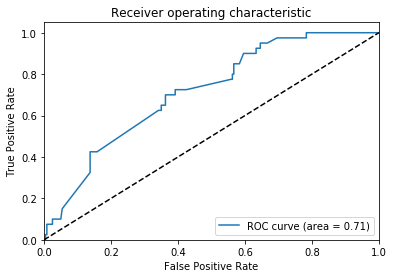

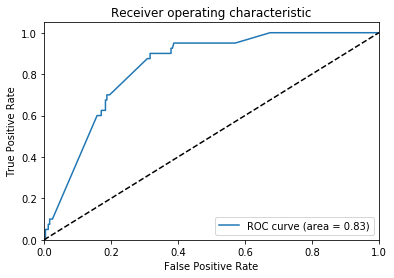

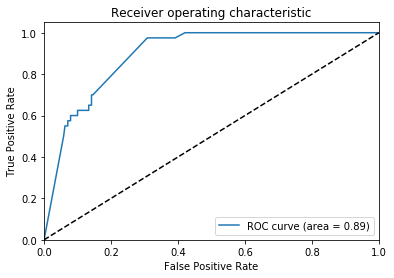

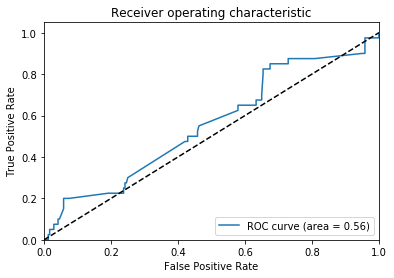

In [97]:
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()